# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# **Introduction**

The problem our project is targeting is music playlist prediction. When listening to music, there is a desire to have song recommendations based on the previous song listened to. This can improve user experience by providing a customized selection tailored to their music taste.

# Spotify Song Prediction Project
Project mentor: Sophia Sklaviadis

Benjamin Fry <bfry2@jh.edu>, Cassie Parent <cparent5@jh.edu>, Alexandra Szewc <aszewc1@jh.edu>

Link to Project Repo: https://github.com/benf549/CS475-Machine-Learning-Final-Project

# Outline and Deliverables

*List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.*

*If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.*

### Uncompleted Deliverables
1. "Expect to complete #2": Determine feature importance in the neural network. We decided to spend more time on improving the performance of our models beyond the baselines.
2. "Would like to accomplish #1": Predict a song based off of a playlist instead of one song. We decided to attempt making predictions off of a raw audio file instead.
3. "Would like to accomplish #2": Add additional features fapart rom the Spotify Audio Analysis API endpoint to incorporate information about the previous song’s musical elements. Instead, we worked on extracting features from a raw audio file.


### Completed Deliverables
1. "Must complete #1": Build a music track dataframe with relevant features [in 'Dataset' below](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
2. "Must complete #2": Select a metric to compare predicted track to “true” value. [in 'Models and Evaluation' below](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).
3. "Must complete #3": Develop a base neural network to predict tracks based on input. [in 'Models and Evaluation: Neural Net' below]().
4. "Expect to complete #1": Optimize model by experimenting with a number of layers, activation functions, dropout, etc. [in 'Models and Evaluation: Enhanced Approach' below]().
5. "Expect to complete #3": Analyze trends in where our network is failing and attempt to explain these difficulties. [in 'Discussion' below]():
6. "Would like to accomplish #3": Compare the supervised neural network to an unsupervised clustering approach. [in 'Results' below]().


### Additional Deliverables
1. We decided to implement the making of predictions that would follow an input audio file. We discuss this [in 'Methods: Enhanced Approach' below]().

# Preliminaries

## What problem were you trying to solve or understand?

The problem we tried to solve is that of providing an adequate recommendation for a next song to be played given a previous song. The real-world applications of this data and task are for music streaming services such as Spotify to provide suitable recommendations to users on what they should listen to next. This problem is similar to others we have seen in lectures, breakouts, and homeworks since it is a a well-defined problem with a lack of an “easy” solutions because most songs are very complex with different keys, beats per minute, instruments used, and more factors. There far too much data available to make any sort of recommendation manually. There are also large amounts of high quality data given by Spotify’s challenge on AI Crowd, which we used for our project. This problem is unique because it carries may different approaches in which one might go about extracting features from a song, modeling song recommendations based on a previous song, and determining a "ground-truth" for which song should come next—which is a problem of its own! All of these are considerations we had to take into accound when deciding how to model this problem. Finally, the ethical implications of this problem include its impact on budding artists or minority artists, as song recommendations may aid or prevent exposure for any artist; the effects of popularity and revenue of the music streaming service like Spotify; and the fact that song recommendations impact the lives of their listeners—perhaps in profound ways that sould not be taken lightly.

## Dataset(s)

The dataset provided by the Spotify Challenge on AICrowd has 1 million playlists. Using a 70/20/10 split would give us over 100,000 examples in our test set. However, to make this project more manageable, we only used a subset of the existing data. Thus, during pre-processing, we randomly selected 10,000 songs from this dataset. 

We then built a dataframe with this dataset using song features from Spotify’s API including tempo, valence, speechiness, loudness, liveness, danceability, and acousticness. We chose this dataset because of its compatibility with the project, size, and availability for use.


Describe the dataset(s) you used.

How were they collected?

Why did you choose them?

How many examples in each?


In [1]:
# Imports
import json, torch, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
if "dense_mtx.npy" in os.listdir():
    dense_mtx = np.load("dense_mtx.npy")
else:
    file_list = [x for x in os.listdir("./temp") if ".npy" in x]
    file_list.sort(key=lambda x : int(x.split("_")[2]))
    
    dense_mtx = np.zeros((22359, 10000))
    
    for idx, chunk in enumerate(file_list):
        chunk_offset = int(chunk.split("_")[2])
        mtx = np.load(f"./temp/{chunk}")
        if idx == len(file_list) - 1:
            num_elem = 59
        else:
            num_elem = 100
        dense_mtx[chunk_offset:chunk_offset+num_elem] = mtx
    
    np.save("dense_mtx.npy", dense_mtx)

In [3]:
labels = []
with open("./temp/npy_chunk_labels.txt", "r") as f:
    for line in f.readlines():
        line = line.strip().replace(".mp3", "")
        labels.append(line)
labels = np.array(labels)
assert(labels.size == dense_mtx.shape[0])

In [4]:
# Read in the JSON data
data_stream = ""
with open("challenge_set.json", "r") as f:
    data_stream = f.read()
data_set = json.loads(data_stream)


# Grab unique track/artist pairs
track_uris = set()
playlist_idcs = []

for i,j in enumerate(data_set["playlists"]):
    if len(j["tracks"]) == 100:
        playlist_idcs.append(i) 
        for track in j["tracks"]:
            track_uris.add((track["track_name"], track["artist_name"], track["track_uri"]))
unique_tracks = list(track_uris)

# Define mapping between URIs and trakcs
uri_to_title_artist_map = {x[2]: (x[0], x[1]) for x in unique_tracks}

# Rearranging data table
df = pd.read_csv("all_downloaded_data.csv")
df = df.drop("Unnamed: 0", axis=1)
df = df.set_index('uri')
df = df.drop_duplicates()

print(df.head())

                                      danceability  energy  key  loudness  \
uri                                                                         
spotify:track:38uqMByifM0mkjcTbejlyR         0.375   0.294    8    -8.751   
spotify:track:4kOTDj4SiZPkW1p96WMDNv         0.950   0.803    1    -4.195   
spotify:track:1c9LBfX0klXJscJAYDI0Ea         0.758   0.501    0    -7.051   
spotify:track:59iNA6gwthoTJ6IgpBGGHW         0.534   0.749    6    -5.562   
spotify:track:4QCng4MDyUhEZ730Ma2Rjp         0.674   0.744   11    -5.196   

                                      mode  speechiness  acousticness  \
uri                                                                     
spotify:track:38uqMByifM0mkjcTbejlyR     1       0.0329        0.9280   
spotify:track:4kOTDj4SiZPkW1p96WMDNv     1       0.1510        0.1450   
spotify:track:1c9LBfX0klXJscJAYDI0Ea     1       0.0589        0.2520   
spotify:track:59iNA6gwthoTJ6IgpBGGHW     0       0.0749        0.0776   
spotify:track:4QCng4MD

## Pre-processing

We chose to use a variety of continuous features—all of which we mentioned in our intial project proposal and follow-up presentation. These include danceability, energy, key, loudness, mode, speechiness, acoustics, instrumentalness, liveness, valence, tempo, and type. Since the data represent the musical qualities of various song tracks within predefined playlists, the classes were not always balanced, as playlists could contain any number of songs, and it was hard to define outliers. Additionally, we simply removed any examples of missing data during our creation of the subset of the data we would move forward with from the original data source.

Although our features are both continuous and categorical, we treated them all similarly in that we normalized the data prior to training the neural network based models, and create maps to link Spotify's identifying URI to a track name and artist name. This would allow us to assess performance in a standardized way.

Additionally, we utilized a train/dev/test split of 70/20/10 on our dataset, and the method of preprocessing is shown below.

In [5]:
# Perform train-test split
data_size = dense_mtx.shape[0]
test_dev_idcs = np.random.choice(data_size, replace=False, size=int(0.3*data_size))

dev_idcs = np.random.choice(test_dev_idcs.shape[0], replace=False, size=int((2/3) * test_dev_idcs.shape[0]))
selected_dev_uris = labels[test_dev_idcs[dev_idcs]]
dev_data = dense_mtx[test_dev_idcs[dev_idcs]]
dev_labels = df.loc[selected_dev_uris].iloc[:, 0:11].to_numpy()

print("dev")
print(dev_data.shape)
print(dev_labels.shape)

test_idcs = np.delete(test_dev_idcs, dev_idcs, axis=0)
selected_test_uris = labels[test_idcs]
test_data = dense_mtx[test_idcs]
test_labels = df.loc[selected_test_uris].iloc[:, 0:11].to_numpy()

print("test")
print(test_data.shape)
print(test_labels.shape)

train_idcs = np.delete(np.arange(data_size), test_dev_idcs, axis=0)
selected_train_uris = labels[train_idcs]
train_data = dense_mtx[train_idcs]
train_labels = df.loc[selected_train_uris].iloc[:, 0:11].to_numpy()

print("train")
print(train_data.shape)
print(train_labels.shape)

# Normalize Data
def normalize(data, mean, std):
    return (data - mean) / std 

train_data_unorm = train_data
dev_data_unorm = dev_data
test_data_unorm = test_data

train_data_means = train_data.mean(axis=0)
train_data_std = train_data.std(axis=0)
train_data = normalize(train_data, train_data_means, train_data_std)

train_label_means = train_labels.mean(axis=0)
train_label_std = train_labels.std(axis=0)
train_labels = normalize(train_labels, train_label_means, train_label_std) 

dev_data = normalize(dev_data, train_data_means, train_data_std)
dev_labels = normalize(dev_labels, train_label_means, train_label_std) 

test_data = normalize(test_data, train_data_means, train_data_std)
test_labels = normalize(test_labels, train_label_means, train_label_std) 

dev
(4471, 10000)
(4471, 11)
test
(2236, 10000)
(2236, 11)
train
(15652, 10000)
(15652, 11)


In [6]:
# For those same examples above, what do they look like after being pre-processed?

# Before
print(np.min(train_data_unorm), np.max(train_data_unorm))
print(np.min(train_data_unorm), np.max(train_data_unorm))
print(np.min(train_data_unorm), np.max(train_data_unorm))

# After
print(np.min(train_data), np.max(train_data))
print(np.min(train_data), np.max(train_data))
print(np.min(train_data), np.max(train_data))

0.0 2870.2985680623215
0.0 2870.2985680623215
0.0 2870.2985680623215
-1.8840863335223412 62.98580274855812
-1.8840863335223412 62.98580274855812
-1.8840863335223412 62.98580274855812


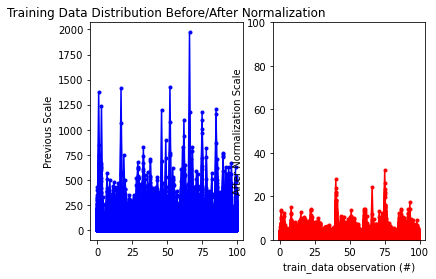

In [7]:
# Visualize the distribution of your data before and after pre-processing.
#   You may borrow from how we visualized data in the Lab homeworks.

x = range(100)
before = train_data_unorm[:100]
after = train_data[:100]

plt.subplot(1, 2, 1)
plt.plot(x, before, 'b.-')
plt.title('Training Data Distribution Before/After Normalization')
plt.ylabel('Previous Scale')


plt.subplot(1, 2, 2)
plt.plot(x, after, 'r.-')
plt.xlabel('train_data observation (#)')
plt.ylabel('After Normalization Scale')
plt.ylim((0, 100))

plt.show()

# Models and Evaluation

## Baselines 

The baselines we compared against were primarily the performance of our own initial Neural Network model. Additionally, we compared against the performances and any available implementations from the [Spotify Million Playlist Dataset Challenge Leaderboard](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/leaderboards).

These baselines were somewat reasonable as a means of comparison. This is because while related work referenced deviated slightly from the aims of our project, it still provided insight into how the sucess of different approaches can vary. Meanwhile, our baseline was reasonable because it provided a benchmark of our initial performance which could be compared to our performance as we attempted different approaches.

# Models and Evaluation: Neural Network

## Experimental Setup

We evaluated this method simply by plotting its loss over the course of training, which is shown in the Results section. There, we observed that the loss did not improve consistently over the course of training, likely due to the high number of classes and sparse nature of our data. The metric we decided to use for this model was mean squared error (MSE) with the [Adam Algorithm](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) to optimize.

We utilized a train/dev/test split of 70/20/10 on our dataset.

Finally, we experimented with a number of different neural network structures by experimenting with the number of layers, activation functions, and dropout methods. Some of our experimentation can be seen in the neural network file linked, as well as through the progress with our enhanced approach.

## Methods

For our baseline neural network model, we employed an architecture with two linear layers and Relu activation and experimented with dropout slightly. We chose this model because it was able to be trained quickly, which allowed us flexibility in some preliminary experimentation.

From this portion of the project, we were first able to see how it can be difficult to implement neural network architectures on large, sparse datasets. Additionally, we experimented slightly with hyperparameters such as learning rate and total epochs, but this did not yet impact our model's performance heavily as the baseline losses were quite high.

The code to this portion of our project can be found at [this location](https://github.com/benf549/CS475-Machine-Learning-Final-Project/blob/main/NeuralNetwork.ipynb) of our project repository.

Below, we can see the evolution of loss over the course of our training of the baseline model.

![Loss over training steps](baseline_loss.png)

# Models and Evaluation: Clustering

## Experimental Setup

We evaluated our clustering model quite differently from our neural network models since it can be difficult to assess the accuracy of clustering algorithms. Therefore, to evaluate this model, we compared our clustering to a projection of our data using the TSNE method. However, it is important to note that "key" was only one of nine features that we used, which is what the TSNE was projected on. Therefore, it would not make sense if the clusters were completely separated off of just this one feature. As we will see below, the clusters tend to stick together, but are not completely isolated.

Additionally, we set up our clustering algorithm by using the ELBO method plotting the WCSS score against the number of clusters and looking for the "corner" in the graph to determine the ideal number of clusters. This aspect of our approach was somewhat validated by the TSNE projection, as there was a similar count of clusters in this projection as where the WCSS score flattened across cluster count.

## Methods

To attempt clustering, we used both KMeans and hierarchical clustering to help visualize and sort our data. We choosed these methods because we believed clustering would be an intuitive way to separate song data into "playlists", which would allow us to select potential good fits for the next song to play.

Although these methods were easy to implement and train due to abstraction through available packages from `sklearn` and `scipy`, it was difficult to evaluate our results as a result of the structure of our initial dataset, which we had to manipulate to obtain our train/dev/test sets. The main hyperparameter we evaluated was the number of clusters, which seemed to greatly affect our models performance through our evaluation using TSNE.

The code to this portion of our project can be found at [this location](https://github.com/benf549/CS475-Machine-Learning-Final-Project/blob/main/k-means-recommender.ipynb) of our project repository.

Below, we can see the ELBO evaluation of the number of clusters, the TSNE visualization of our dataset, and a dendrogram created using `scipy.cluster.hierarchy` that describes our song dataset.

![ELBO plot](elbo.png)

![TSNE plot](tsne.png)

![Dendrogram](dendrogram.png)

# Models and Evaluation: Enhanced Approach

## Experimental Setup

We again evaluated this method simply by plotting its loss over the course of training, which is shown in the Results section. This time, we observed that the loss *did* improve consistently over the course of training as a result of our experimentation with model architecture and the application of suggestions from our presentation. The metric we decided to use for this model was mean squared error (MSE) with the [Adam Algorithm](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) to optimize. We did this to maintain consistency with our baseline approach. Again, we utilized a train/dev/test split of 70/20/10 on our dataset.

Finally, we experimented with making recommendations based on raw input sound files to see our model in action.


## Methods

To reiterate, for this portion of our project, we utilized more advanced nerual network models to solve our identified problem. We chose these methods in order to incorporate both of the previous approaches mentioned, as well as to attempt to include suggestions given by our mentor and other groups during our presentation.

We trained this model by experimenting with different neural network architectures and evaluating their performances in terms of final loss at the end of training. Then, we selected the best model which had the lowest losses on the dev dataset. This final model had three linear layers and utilized both Relu and tanh activation.

These enhanced models were more difficult to implement, since they were quite involved computationally. This made evaluation solely on final loss challenging.

The code to this portion of our project can be found at [this location](https://github.com/benf549/CS475-Machine-Learning-Final-Project/blob/main/fourier_NN.ipynb) of our project repository.

Below, we can see both the Normalized Fourier Spectra followed by the predicted labels for a selection of different test indices, which give some insight into our final model's performance after training.

![Normalized Fourier Spectra](spectra.png)

![Predicted Labels](pred_labels.png)

## Results

The baselines we found on the [Spotify Million Playlist Dataset Challenge Leaderboard](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/leaderboards) had a top R-Precision of 0.220.

Meanwhile, our initial neural network had an minimum dev loss of about 25. These results cannot quite be compared due to the fact that our models were not designed to recommend entire playlists, but rather singular songs.

The fact that our final model's loss of 0.74 was so much lower than that of our initial neural network surprised us. This is because in the grand scheme, our final model did not have seemingly too different of an architecture from the baseline network, with only one more linear layer and the use of an additional activation function. However, we believe our model may have overfit due to this suprising improvement in performance. To address this,we incorporated a dropout rate of 0.75, which we included in our reported model.

The evaluation of our trained models tells us our data is highly variable and complex. On less complex data with fewer or at least less variable attributes, we expect that the performances of all of our models would have been far more consistent.

### Enhanced Approach

The loss across epochs that resulted from the enhanced approach is shown below. The final loss on the dev set was 0.74. This model may have over-fitted, which we 

![Enhanced Approach: Loss 0.74](models/0.74_3_layer_linear_relu_tanh.pth.png)

# Discussion

## What you've learned

*What concepts from lecture/breakout were most relevant to your project? How so?*

The concepts from the lecture and breakout rooms that were most relevant to our project were the introductions to both PyTorch and K-Means clustering. Additionally, we found the lectures on clustering, neural networks, and FATE to be helpful in informing the direction of our project implementation. Finally, we found the feedback we gained from our presentation to help us find new directions for our project after facing some difficulties—which is how we came to the results we presented here.

*What aspects of your project did you find most surprising? What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not*

We were collectively surprised in the difficulty we had structuring the training of a neural network  due to poor performance when trying to classify between so many songs, but soon understood why this was the case. Our surprise at this aspect that became relatively obvious in hindisght taught us the importance of planning extensively prior to undertaking any ML project. This is a lesson that owuld transfer to other datasets, models, and projects because understanding the data being worked with and the problem being solved—as well as how the solution is to be arrived at—are important steps to successfuly developing a machine learning framework to answer the question at hand. Without prioritizing good project design from the start, it becomes difficult to identify problems with the design and further develop the project. Our group ran into these problems as a result of reduced time to work on the project due to changing our proposal due to TA recommendations. In the future, we will all be careful to define our problem well before starting another project.

*What was the most helpful feedback you received during your presentation? Why?*

The most helpful feedback we received during our presentation was adding different embedding layers into our neural network model since the input dataset was sparse. By experimenting with manipulating and preprocessing our data even prior to feeding it into our neural network model, we were able to achieve far more favorable performance.

*If you had two more weeks to work on this project, what would you do next? Why?*

With two more weeks to work on the project, we would implement further suggestions given during our presentation, such as to fully combine the two approaches we identified as deliverables during our proposal and presentation: clustering and neural networks. To do this, we experimented with several neural networks to predict the desired labels prior to feeding our results into a clustering model. This approach was very informative to us to implement, and allowed us to understand how different models can interact to augment performance results. Additionally, we would have looked into extracting additional metadata about the songs—such as reviews, genre, and tags—since these additional features do not relate to the musical properties of the songs themselves, unlike our current features.